<h1 align="center"> <span style="font-size: 20px;"> Proyecto Final Grupo Nº 7 </span> <br>
    <align="center"> <span style="font-size: 15px;">  Proyecto Yelp & Google Maps - Reviewa y Recomendaciones</span><br>         
<align="center"> <span style="font-size: 15px;">@utores:  Javier Castro, Luca Ramallo, Luis Ramírez, Lesmen García.</span> <br>
  <a href="https://github.com/lesmengp/Proyecto-Final-Grupo-07.git">GitHub: <span style="font-size: 20px;">Proyecto Yelp & Google Maps</span></a> 
</h1>

# Modelo de ML con SVM (Support Vector Machines)

### Target = Promedios de Sentimientos Positivos

### Librerías a Utilizar:

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
import io
import json
import gcsfs
import ast
from textblob import TextBlob   #0.17.1
import pandas as pd
import folium
import webbrowser
import textwrap
from folium.plugins import MarkerCluster

In [2]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
%matplotlib inline 
import matplotlib.pyplot as plt

In [3]:
############################################
### Funcion para Cargar Archivos PARQUET ###
############################################
def Cargar_Archivo_PARQUET(nombre_archivo, ubicacion):
    file = os.path.join(ubicacion, nombre_archivo)
    try:
        df = pd.read_parquet(file)
        print("Archivo cargado exitosamente en un DataFrame.")
    except FileNotFoundError:
        print("El archivo no se encontró en la ruta especificada.")
    except Exception as e:
        print("Ocurrió un error al cargar el archivo:", str(e))
    return df

### Cargando Dataset Consolidado Final para ML: 'df_ML_promedios_Final.parquet'

In [4]:
### Cargando DataSets Consolidado para Análisis de ML: 'df_business_yelp_ML.parquet'
# Ruta completa en Cloud Storage
ruta_eda_datalike = "gs://gmy/Datasets_ML/df_ML_promedios_Final.parquet"

# Lee el archivo Parquet directamente en un DataFrame de pandas
df_ML_promedios_Final = pd.read_parquet(ruta_eda_datalike, storage_options={"project": "Proyecto Final - Henry"})
df_ML_promedios_Final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49334 entries, 0 to 49333
Data columns (total 61 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   business_id                         49334 non-null  object 
 1   name                                49334 non-null  object 
 2   address                             49334 non-null  object 
 3   city                                49334 non-null  object 
 4   state                               49334 non-null  object 
 5   postal_code                         49334 non-null  object 
 6   latitude                            49334 non-null  float64
 7   longitude                           49334 non-null  float64
 8   stars                               49334 non-null  float64
 9   review_count                        49334 non-null  int16  
 10  is_open                             49334 non-null  int8   
 11  RestaurantsTakeOut                  49334

In [6]:
### Visualizando Columnas Sentimientos
df_ML_promedios_Final[['promedio_sentimientos_positivos','promedio_sentimientos_negativos','promedio_sentimientos_positivosTip','promedio_sentimientos_negativosTip','promedio_compliment_count_Tip']]

,promedio_sentimientos_positivos,promedio_sentimientos_negativos,promedio_sentimientos_positivosTip,promedio_sentimientos_negativosTip,promedio_compliment_count_Tip
0,0.942529,0.057471,0.800000,0.200000,0.0
1,0.923077,0.076923,1.000000,0.000000,0.0
2,0.500000,0.500000,0.500000,0.500000,0.0
3,0.700000,0.300000,0.500000,0.500000,0.0
4,0.909091,0.090909,1.000000,0.000000,0.0
...,...,...,...,...,...
49329,0.852941,0.147059,0.333333,0.666667,0.0
49330,0.953488,0.046512,0.833333,0.166667,0.0
49331,0.971429,0.028571,0.750000,0.250000,0.0
49332,0.857143,0.142857,1.000000,0.000000,0.0


### Seleccionando Variables Categoricas y Númericas

In [7]:
### Seleccionando Variables Categoricas y Númericas

df_variables_categoricas = df_ML_promedios_Final.select_dtypes(include=['object', 'category'])
df_variables_numericas = df_ML_promedios_Final.select_dtypes(include='number')

print(f"Total Variables Categoricas {df_variables_categoricas.shape[1]}\n {df_variables_categoricas.columns}\n")
print("="*90)
print(f"Total Variables Númericas {df_variables_numericas.shape[1]}\n {df_variables_numericas.columns}\n")

Total Variables Categoricas 8
 Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'BusinessParking', 'RestaurantsPriceRange2'],
      dtype='object')

Total Variables Númericas 53
 Index(['latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'RestaurantsTakeOut', 'BusinessAcceptsCreditCards',
       'RestaurantsDelivery', 'OutdoorSeating', 'BikeParking',
       'RestaurantsReservations', 'WiFi', 'HasTV', 'Monday', 'Tuesday',
       'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',
       'average_stars', 'total_sentimientos',
       'promedio_sentimientos_positivos', 'promedio_sentimientos_negativos',
       'Promedio_useful', 'Promedio_funny', 'Promedio_cool',
       'total_sentimientosTip', 'promedio_sentimientos_positivosTip',
       'promedio_sentimientos_negativosTip', 'promedio_compliment_count_Tip',
       'A_M_Monday', 'A_T_Monday', 'A_N_Monday', 'A_M_Tuesday', 'A_T_Tuesday',
       'A_N_Tuesday', 'A_M_Wednesday', 'A_T_Wednesday

### Análisis de Correlaciones 

In [46]:
df_variables_numericas.head(3)

,latitude,longitude,stars,review_count,is_open,RestaurantsTakeOut,BusinessAcceptsCreditCards,RestaurantsDelivery,OutdoorSeating,BikeParking,...,A_M_Friday,A_T_Friday,A_N_Friday,A_M_Saturday,A_T_Saturday,A_N_Saturday,A_M_Sunday,A_T_Sunday,A_N_Sunday,Total_Horas_Semana
0,39.955505,-75.155564,4.0,80,1,1,0,0,0,1,...,1,0,0,1,0,0,1,0,0,94.0
1,40.338183,-75.471659,4.5,13,1,1,1,0,0,1,...,0,1,0,0,1,0,0,1,0,40.0
2,36.269593,-87.058943,2.0,6,1,1,1,1,1,0,...,1,0,0,1,0,0,1,0,0,66.0


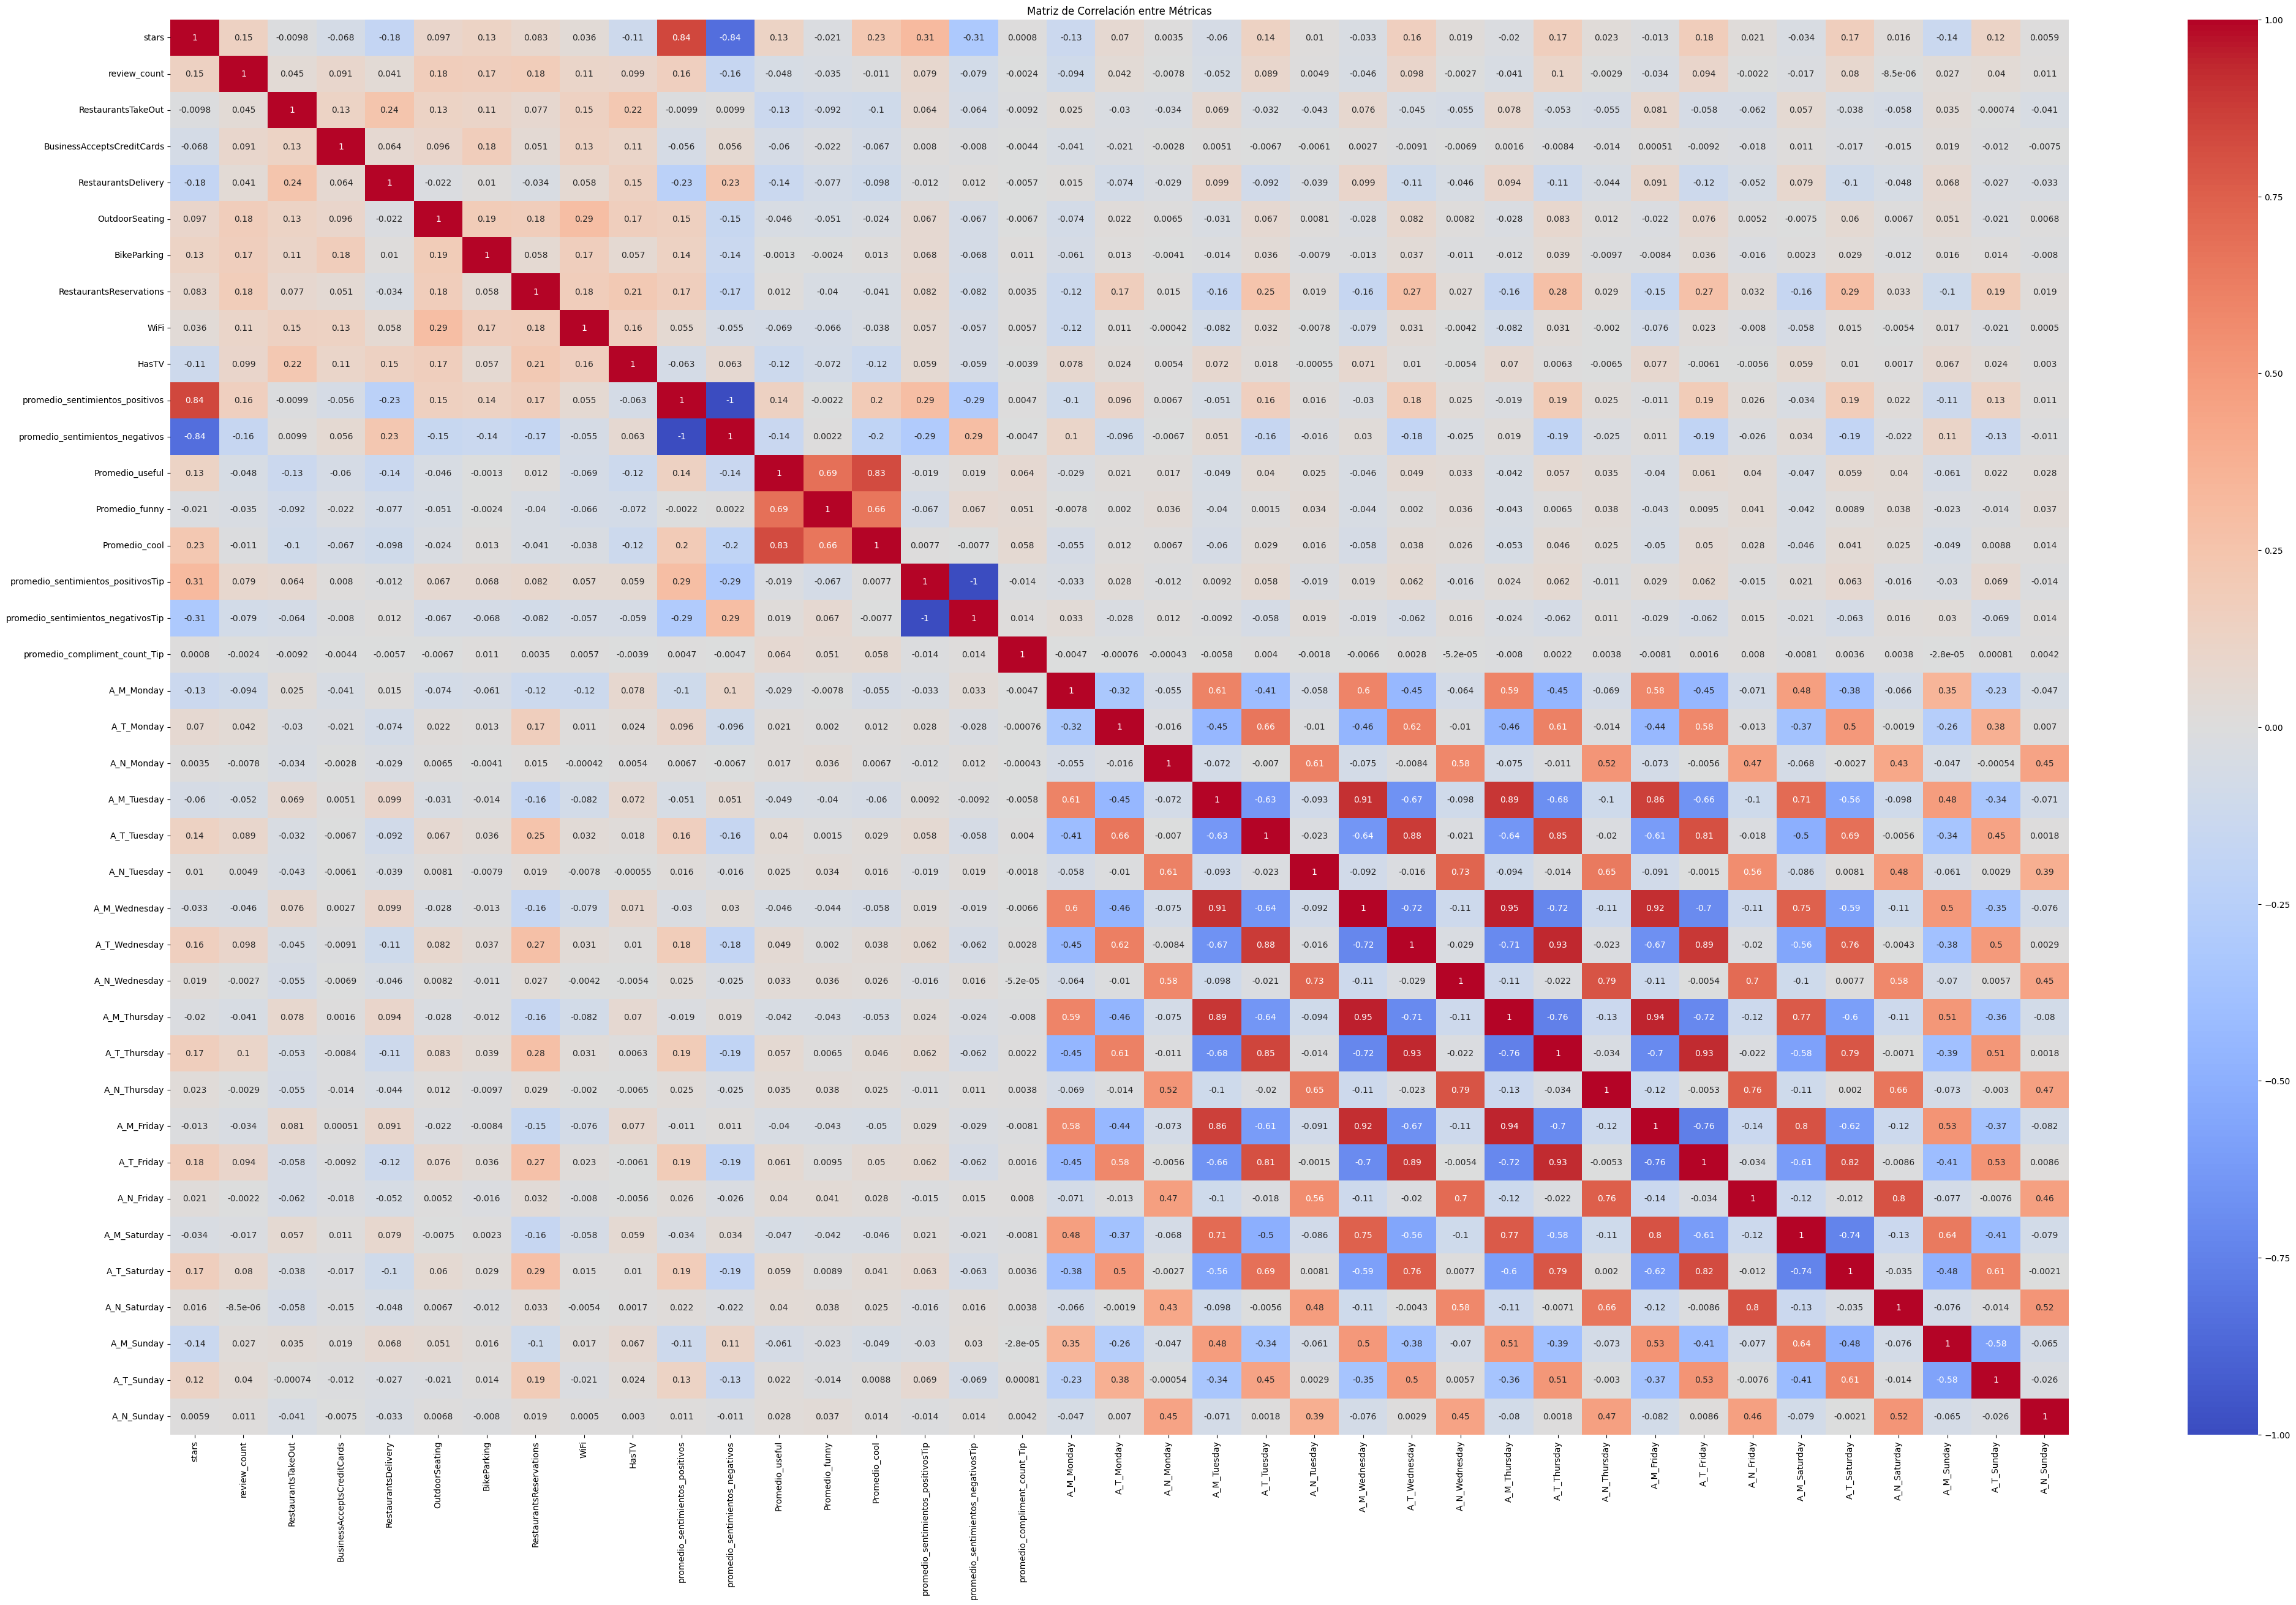

In [8]:
columnas_numericas = ['stars', 'review_count', 
        'RestaurantsTakeOut', 'BusinessAcceptsCreditCards',
        'RestaurantsDelivery', 'OutdoorSeating', 'BikeParking',
        'RestaurantsReservations', 'WiFi', 'HasTV', 
#        'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',
#        'average_stars', 'total_sentimientos',
        'promedio_sentimientos_positivos', 
        'promedio_sentimientos_negativos',
        'Promedio_useful', 'Promedio_funny', 'Promedio_cool',
#        'total_sentimientosTip', 
        'promedio_sentimientos_positivosTip',
        'promedio_sentimientos_negativosTip', 
        'promedio_compliment_count_Tip',
        'A_M_Monday', 'A_T_Monday', 'A_N_Monday', 
        'A_M_Tuesday', 'A_T_Tuesday', 'A_N_Tuesday',
        'A_M_Wednesday', 'A_T_Wednesday', 'A_N_Wednesday',
        'A_M_Thursday', 'A_T_Thursday', 'A_N_Thursday',
        'A_M_Friday', 'A_T_Friday', 'A_N_Friday',
        'A_M_Saturday', 'A_T_Saturday', 'A_N_Saturday',
        'A_M_Sunday', 'A_T_Sunday', 'A_N_Sunday',
#        'Total_Horas_Semana'
                     ]

# Selecciona las columnas numéricas para el análisis de correlación

# Selecciona las variables
DataSets = ['df_ML_promedios_Final']

Columnas_a_Correlacionar = columnas_numericas

for dataset in DataSets:
    df = globals()[dataset]

    # Filtra el DataFrame para incluir solo las columnas numéricas
    df_numericas = df[Columnas_a_Correlacionar]

    # Calcula la matriz de correlación
    matriz_correlacion = df_numericas.corr()

    # Crea un mapa de calor (heatmap) para visualizar la matriz de correlación
    plt.figure(figsize=(50, 30))
    sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', center=0)
    plt.title('Matriz de Correlación entre Métricas')
    #plt.savefig("../src/Graficas/Correlaciones.png")
    plt.show()

In [10]:
columnas_numericas = ['stars', 'review_count', 
        'RestaurantsTakeOut', 'BusinessAcceptsCreditCards',
        'RestaurantsDelivery', 'OutdoorSeating', 'BikeParking',
        'RestaurantsReservations', 'WiFi', 'HasTV', 
#        'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',
#        'average_stars', 'total_sentimientos',
        'promedio_sentimientos_positivos', 
        'promedio_sentimientos_negativos',
        'Promedio_useful', 'Promedio_funny', 'Promedio_cool',
#        'total_sentimientosTip', 
        'promedio_sentimientos_positivosTip',
        'promedio_sentimientos_negativosTip', 
        'promedio_compliment_count_Tip',
        'A_M_Monday', 'A_T_Monday', 'A_N_Monday', 
        'A_M_Tuesday', 'A_T_Tuesday', 'A_N_Tuesday',
        'A_M_Wednesday', 'A_T_Wednesday', 'A_N_Wednesday',
        'A_M_Thursday', 'A_T_Thursday', 'A_N_Thursday',
        'A_M_Friday', 'A_T_Friday', 'A_N_Friday',
        'A_M_Saturday', 'A_T_Saturday', 'A_N_Saturday',
        'A_M_Sunday', 'A_T_Sunday', 'A_N_Sunday',
#        'Total_Horas_Semana'
                     ]

In [11]:
print(columnas_numericas)

['stars', 'review_count', 'RestaurantsTakeOut', 'BusinessAcceptsCreditCards', 'RestaurantsDelivery', 'OutdoorSeating', 'BikeParking', 'RestaurantsReservations', 'WiFi', 'HasTV', 'promedio_sentimientos_positivos', 'promedio_sentimientos_negativos', 'Promedio_useful', 'Promedio_funny', 'Promedio_cool', 'promedio_sentimientos_positivosTip', 'promedio_sentimientos_negativosTip', 'promedio_compliment_count_Tip', 'A_M_Monday', 'A_T_Monday', 'A_N_Monday', 'A_M_Tuesday', 'A_T_Tuesday', 'A_N_Tuesday', 'A_M_Wednesday', 'A_T_Wednesday', 'A_N_Wednesday', 'A_M_Thursday', 'A_T_Thursday', 'A_N_Thursday', 'A_M_Friday', 'A_T_Friday', 'A_N_Friday', 'A_M_Saturday', 'A_T_Saturday', 'A_N_Saturday', 'A_M_Sunday', 'A_T_Sunday', 'A_N_Sunday']


In [12]:
### Por requerimientos de skitkearn algorithm debemos trabajar con valores enteros

df_ml = df_ML_promedios_Final[columnas_numericas]

df_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49334 entries, 0 to 49333
Data columns (total 39 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   stars                               49334 non-null  float64
 1   review_count                        49334 non-null  int16  
 2   RestaurantsTakeOut                  49334 non-null  int64  
 3   BusinessAcceptsCreditCards          49334 non-null  int64  
 4   RestaurantsDelivery                 49334 non-null  int64  
 5   OutdoorSeating                      49334 non-null  int64  
 6   BikeParking                         49334 non-null  int64  
 7   RestaurantsReservations             49334 non-null  int64  
 8   WiFi                                49334 non-null  int64  
 9   HasTV                               49334 non-null  int64  
 10  promedio_sentimientos_positivos     49334 non-null  float64
 11  promedio_sentimientos_negativos     49334

### Normalizando Columna de 'promedio_sentimientos_positivos' a 1 y 0

In [13]:
### Normalizando Columna de Sentimientos 'promedio_sentimientos_positivos'
# Crea una nueva columna 'binario' con valores 1 si 'valor' es mayor o igual a 4, de lo contrario, 0

df_ml['Diferencia_Promedios_Sentimientos'] = df_ml['promedio_sentimientos_positivos'] - df_ml['promedio_sentimientos_negativos']
df_ml['SentimientosPositivos'] = df_ml['Diferencia_Promedios_Sentimientos'].apply(lambda x: 1 if x > 0 else 0)

df_ml['SentimientosPositivos'] = df_ml['SentimientosPositivos'].astype('int')

df_ml[['Diferencia_Promedios_Sentimientos','SentimientosPositivos']]

/var/tmp/ipykernel_60654/452160296.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ml['Diferencia_Promedios_Sentimientos'] = df_ml['promedio_sentimientos_positivos'] - df_ml['promedio_sentimientos_negativos']
/var/tmp/ipykernel_60654/452160296.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ml['SentimientosPositivos'] = df_ml['Diferencia_Promedios_Sentimientos'].apply(lambda x: 1 if x > 0 else 0)
/var/tmp/ipykernel_60654/452160296.py:7: SettingWithCopyWarning: 
A value is trying to be set on a

,Diferencia_Promedios_Sentimientos,SentimientosPositivos
0,0.885057,1
1,0.846154,1
2,0.000000,0
3,0.400000,1
4,0.818182,1
...,...,...
49329,0.705882,1
49330,0.906977,1
49331,0.942857,1
49332,0.714286,1


In [14]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49334 entries, 0 to 49333
Data columns (total 41 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   stars                               49334 non-null  float64
 1   review_count                        49334 non-null  int16  
 2   RestaurantsTakeOut                  49334 non-null  int64  
 3   BusinessAcceptsCreditCards          49334 non-null  int64  
 4   RestaurantsDelivery                 49334 non-null  int64  
 5   OutdoorSeating                      49334 non-null  int64  
 6   BikeParking                         49334 non-null  int64  
 7   RestaurantsReservations             49334 non-null  int64  
 8   WiFi                                49334 non-null  int64  
 9   HasTV                               49334 non-null  int64  
 10  promedio_sentimientos_positivos     49334 non-null  float64
 11  promedio_sentimientos_negativos     49334

In [15]:
df_ml.columns

Index(['stars', 'review_count', 'RestaurantsTakeOut',
       'BusinessAcceptsCreditCards', 'RestaurantsDelivery', 'OutdoorSeating',
       'BikeParking', 'RestaurantsReservations', 'WiFi', 'HasTV',
       'promedio_sentimientos_positivos', 'promedio_sentimientos_negativos',
       'Promedio_useful', 'Promedio_funny', 'Promedio_cool',
       'promedio_sentimientos_positivosTip',
       'promedio_sentimientos_negativosTip', 'promedio_compliment_count_Tip',
       'A_M_Monday', 'A_T_Monday', 'A_N_Monday', 'A_M_Tuesday', 'A_T_Tuesday',
       'A_N_Tuesday', 'A_M_Wednesday', 'A_T_Wednesday', 'A_N_Wednesday',
       'A_M_Thursday', 'A_T_Thursday', 'A_N_Thursday', 'A_M_Friday',
       'A_T_Friday', 'A_N_Friday', 'A_M_Saturday', 'A_T_Saturday',
       'A_N_Saturday', 'A_M_Sunday', 'A_T_Sunday', 'A_N_Sunday',
       'Diferencia_Promedios_Sentimientos', 'SentimientosPositivos'],
      dtype='object')

In [16]:
df_ml.shape

(49334, 41)

In [18]:
ColumnasModelo_ML = ['stars', 'review_count', 'RestaurantsTakeOut',
       'BusinessAcceptsCreditCards', 'RestaurantsDelivery', 'OutdoorSeating',
       'BikeParking', 'RestaurantsReservations', 'WiFi', 'HasTV',
#       'promedio_sentimientos_positivos',
#       'promedio_sentimientos_negativos',
       'Promedio_useful', 'Promedio_funny', 'Promedio_cool',
       'promedio_sentimientos_positivosTip',
       'promedio_sentimientos_negativosTip', 'promedio_compliment_count_Tip',
       'A_M_Monday', 'A_T_Monday', 'A_N_Monday', 'A_M_Tuesday', 'A_T_Tuesday',
       'A_N_Tuesday', 'A_M_Wednesday', 'A_T_Wednesday', 'A_N_Wednesday',
       'A_M_Thursday', 'A_T_Thursday', 'A_N_Thursday', 'A_M_Friday',
       'A_T_Friday', 'A_N_Friday', 'A_M_Saturday', 'A_T_Saturday',
       'A_N_Saturday', 'A_M_Sunday', 'A_T_Sunday', 'A_N_Sunday',
        ]

### Defenimos las variables 'X' y 'y' para nuestro modelo

In [19]:
### Defenimos las variables 'X' nuestro modelo
X = np.asarray(df_ml[ColumnasModelo_ML])
X[0:5]

array([[ 4.        , 80.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  1.        ,  0.        ,
         1.50574713,  0.54022989,  1.09195402,  0.8       ,  0.2       ,
         0.        ,  1.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ],
       [ 4.5       , 13.        ,  1.        ,  1.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.15384615,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  1.        ,
         0.     

In [20]:
y = np.asarray(df_ml['SentimientosPositivos'])
y [0:5]

array([1, 1, 0, 1, 1])

## Train/Test dataset

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)

print ('Train set:', X_train.shape,  y_train.shape)

print ('Test set:', X_test.shape,  y_test.shape)

Train set: (39467, 37) (39467,)
Test set: (9867, 37) (9867,)


<h2 id="modeling">Modeling (SVM with Scikit-learn)</h2>

In [22]:
from sklearn import svm

# Crear un modelo de regresión logística
clf = svm.SVC(kernel='rbf')

# Entrenar el modelo con los datos de entrenamiento
clf.fit(X_train, y_train) 


SVC()

### Prediciendo

In [26]:
# Predecir en el conjunto de prueba
yhat = clf.predict(X_test)
yhat [0:5]

array([1, 1, 1, 1, 1])

### Evaluacion

In [27]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [28]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       590
           1       0.94      1.00      0.97      9277

    accuracy                           0.94      9867
   macro avg       0.47      0.50      0.48      9867
weighted avg       0.88      0.94      0.91      9867

Confusion matrix, without normalization
[[   0  590]
 [   0 9277]]


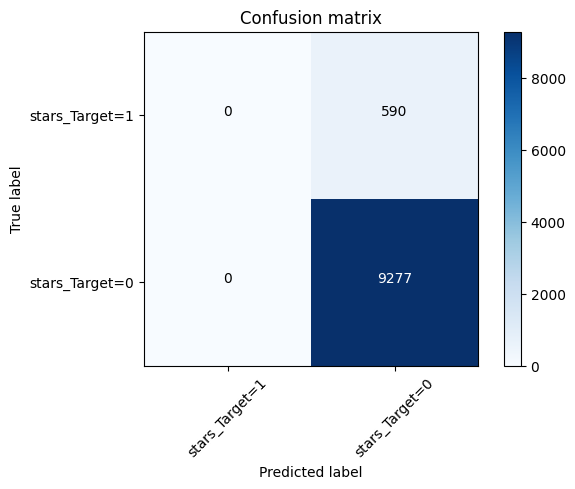

In [29]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[0,1])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['stars_Target=1','stars_Target=0'],normalize= False,  title='Confusion matrix')

**f1\_score** from sklearn library:

In [30]:
from sklearn.metrics import f1_score
f1_score(y_test, yhat, average='weighted') 

0.9112285012056083

**Indice Jaccard** for accuracy:

In [34]:
from sklearn.metrics import jaccard_score
jaccard_score(y_test, yhat,pos_label=0)

0.0

In [33]:
from sklearn.metrics import jaccard_score
jaccard_score(y_test, yhat,pos_label=1)

0.9402047228134185

### Fin